In [270]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

from sklearn.ensemble import IsolationForest

from config.config import TOTAL_DAYS, PATH_TO_DATA
# рассматриваем данные за первые TOTAL_DAYS дней активности
from utils.df_creation import get_users, create_interaction, get_target, get_min_timestamps,\
    cut_df_by_time, cut_dfs_by_time, get_action_counts_by_period, get_base_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
events_ = events.copy()

events_['date'] = events.time.dt.date
events_['hour'] = events.time.dt.floor('H')

print(events_.groupby('user_id').agg({
        'date': 'nunique',  # количество уникальных дней в events
        'hour': 'nunique' # количество уникальных часов в events
    }))

del events_

         date  hour
user_id            
1           1     1
2           2     2
3           7    28
5           2     2
7           1     1
...       ...   ...
26790       4     4
26793       1     1
26794       9    28
26797       2     3
26798       1     2

[19234 rows x 2 columns]


In [245]:
TOTAL_DAYS

2

# Загрузка данных и sanity checks

In [43]:
events = pd.read_csv(os.path.join(PATH_TO_DATA, 'events_data_train.zip'))
submissions = pd.read_csv(os.path.join(PATH_TO_DATA, 'submissions_data_train.zip'))

events_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'events_data_test.zip'))
submissions_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'submissions_data_test.zip'))

In [44]:
events['time'] = pd.to_datetime(events.timestamp, unit='s')
submissions['time'] = pd.to_datetime(submissions.timestamp, unit='s')

events_test['time'] = pd.to_datetime(events_test.timestamp, unit='s')
submissions_test['time'] = pd.to_datetime(submissions_test.timestamp, unit='s')

In [45]:
events.head()

,step_id,timestamp,action,user_id,time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [46]:
submissions.head()

,step_id,timestamp,submission_status,user_id,time
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03


Проверим, какие варианты действий есть.

In [47]:
print(events.action.unique())
print(submissions.submission_status.unique())

['viewed' 'passed' 'discovered' 'started_attempt']
['correct' 'wrong']


Данные в тренировочной и тестовой выборках разделены по времени:

In [48]:
events.time.min(), events.time.max()

(Timestamp('2015-06-15 04:00:48'), Timestamp('2018-05-19 23:33:31'))

In [49]:
submissions.time.min(), submissions.time.max()

(Timestamp('2015-06-15 04:02:24'), Timestamp('2018-05-19 23:07:07'))

In [50]:
events_test.time.min(), events_test.time.max()

(Timestamp('2018-05-20 03:59:01'), Timestamp('2019-01-20 17:00:43'))

In [51]:
submissions_test.time.min(), submissions_test.time.max()

(Timestamp('2018-05-20 07:07:49'), Timestamp('2019-01-20 16:53:38'))

И по пользователям тоже:

In [52]:
np.intersect1d(events.user_id.unique(), events_test.user_id.unique())

array([], dtype=int64)

Нет пользователей без ивентов, но с сабмитами:

In [53]:
np.setdiff1d(submissions['user_id'].values, events['user_id'].values)

array([], dtype=int64)

In [54]:
np.setdiff1d(submissions_test['user_id'].values, events_test['user_id'].values)

array([], dtype=int64)

Проверим, что множества степов в тренировочной и тестовой выборке совпадают:

In [55]:
print(np.setdiff1d(submissions.step_id.unique(), submissions_test.step_id.unique()))
print(np.setdiff1d(submissions_test.step_id.unique(), submissions.step_id.unique()))

[33676 33681 33686 33734 33983 33984 34041]
[]


Есть различия, но можно посмотреть, что в каждом из этих степов довольно мало действий. Видимо, это одни из последних задач на курсе, которые просто никто не успел решить за два дня от начала курса.

In [252]:
events_test.query('step_id == 34041')

,step_id,timestamp,action,user_id,time
738,34041,1527052678,viewed,12684,2018-05-23 05:17:58
739,34041,1527052679,started_attempt,12684,2018-05-23 05:17:59
740,34041,1527052678,discovered,12684,2018-05-23 05:17:58
31872,34041,1530847853,viewed,1459,2018-07-06 03:30:53
31873,34041,1530847853,started_attempt,1459,2018-07-06 03:30:53
31874,34041,1530847853,discovered,1459,2018-07-06 03:30:53
36797,34041,1532610539,viewed,1800,2018-07-26 13:08:59
36798,34041,1532610536,started_attempt,1800,2018-07-26 13:08:56
36799,34041,1532610539,discovered,1800,2018-07-26 13:08:59
51442,34041,1537030758,viewed,24169,2018-09-15 16:59:18


In [254]:
strange_problems = np.setdiff1d(submissions.step_id.unique(), submissions_test.step_id.unique())
all('started_attempt' in events_test.query('step_id == @step').action.unique() for step in strange_problems)

True

In [56]:
print(np.setdiff1d(events.step_id.unique(), events_test.step_id.unique()))
print(np.setdiff1d(events_test.step_id.unique(), events.step_id.unique()))

[]
[]


Сохраним, какие степы относятся к задачам, а какие нет:

In [57]:
problem_steps = submissions.step_id.unique()
non_problem_steps = np.setdiff1d(events.step_id.unique(), problem_steps)

# Создание датасетов, анализ базовых признаков

Для каждого пользователя будем рассматривать только первые двое суток его активности, как указано в условии. В курсе предлагается получить все активности в течение двух суток после первого действия в каждой таблице, что не совсем корректно, так как между первым ивентом и первым сабмитом может пройти достаточно много времени и в этом случае мы будем брать данные из будущего. Поэтому мы объединяем две таблицы в одну и берем первые двое суток после первого действия.

In [65]:
events_2d, submissions_2d = cut_dfs_by_time(events, submissions)
events_test, submissions_test = cut_dfs_by_time(events_test, submissions_test)

In [262]:
events_2d, submissions_2d = cut_dfs_by_time(events, submissions)
events_test, submissions_test = cut_dfs_by_time(events_test, submissions_test)

In [66]:
all_actions_2d = create_interaction(events_2d, submissions_2d)
all_actions = create_interaction(events, submissions)
all_actions_test = create_interaction(events_test, submissions_test)

In [263]:
all_actions_2d = create_interaction(events_2d, submissions_2d)
all_actions = create_interaction(events, submissions)
all_actions_test = create_interaction(events_test, submissions_test)

all_actions_2d.head()

,step_id,timestamp,action,user_id,time
1596009,31981,1472827464,discovered,1,2016-09-02 14:44:24
1596008,31981,1472827464,viewed,1,2016-09-02 14:44:24
3040121,32815,1514383364,discovered,2,2017-12-27 14:02:44
3040123,32815,1514383364,passed,2,2017-12-27 14:02:44
3040122,32815,1514383364,viewed,2,2017-12-27 14:02:44


In [264]:
all(pd.Series(['discovered', 'passed', 'started_attempt', 'viewed', 'correct', 'wrong']).isin(all_actions_2d.action.unique()))

True

Создадим таблицу с базовыми признаками для каждого пользователя, посчитав общее количество всех действий для него:

In [277]:
train_df = get_base_features(all_actions_2d, target=get_target(all_actions))
train_df_all = get_base_features(all_actions, target=get_target(all_actions))
test_df = get_base_features(all_actions_test)

train_df.head()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
1,1,0,0,1,0,0,1,0
2,9,9,2,9,2,0,1,0
3,15,15,4,20,4,4,1,0
5,1,1,0,1,0,0,1,0
7,1,1,0,1,0,0,1,0


In [298]:
train_df.iloc[:, :-1].to_csv(os.path.join(PATH_TO_DATA, 'train_data_base.csv'))
train_df.iloc[:, -1].to_csv(os.path.join(PATH_TO_DATA, 'targets.csv'))
test_df.to_csv(os.path.join(PATH_TO_DATA, 'test_data_base.csv'))

Проверим, сколько пользователей сделали первый сабмит больше через 2 дня после того, как начали курс (то есть не имеют сабмитов в нашей методологии, но имеют в той, которая описана в курсе).

In [93]:
submissions_2d_wrong = cut_df_by_time(submissions)

slow_users = np.setdiff1d(
    submissions_2d_wrong.merge(
        events_2d.groupby('user_id')[['timestamp']].min().rename(columns={'timestamp': 'min_timestamp'}) + 2 * 24 * 3600,
        on='user_id'
        ).query('timestamp > min_timestamp').user_id.unique(),
    submissions_2d_wrong.merge(
        events_2d.groupby('user_id')[['timestamp']].min().rename(columns={'timestamp': 'min_timestamp'}) + 2 * 24 * 3600,
        on='user_id'
        ).query('timestamp <= min_timestamp').user_id.unique()
)

del submissions_2d_wrong

slow_users.shape

(1125,)

А сколько из них окончили?

In [94]:
print(train_df.passed_course[train_df.index.isin(slow_users)].value_counts())
del slow_users

0    899
1    226
Name: passed_course, dtype: int64


Придется мириться с тем, что этих 226 юзеров априори неправильно будем классифицировать.

Посмотрим простые статистики тренировочной и тестовой выборок:

In [95]:
train_df.iloc[:, :-1].describe()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
count,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000
mean,12.364875,11.407040,4.109754,19.232973,3.163201,2.840023,1.343298
std,18.037964,16.814163,8.034247,32.075203,6.306553,9.082522,0.625138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,6.000000,5.000000,1.000000,7.000000,0.000000,0.000000,1.000000
75%,16.000000,14.000000,5.000000,23.750000,2.000000,1.000000,2.000000
max,198.000000,198.000000,135.000000,568.000000,76.000000,184.000000,3.000000


In [96]:
test_df.describe()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
count,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000
mean,10.877749,10.083603,4.344599,19.126132,2.825841,2.842820,1.303364
std,17.601541,16.496344,9.096022,41.319291,6.143144,10.725406,0.605769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,2.000000,2.000000,1.000000,3.000000,0.000000,0.000000,1.000000
75%,12.000000,11.000000,4.000000,17.000000,2.000000,0.000000,1.000000
max,180.000000,151.000000,113.000000,543.000000,46.000000,166.000000,3.000000


Видим, что некоторые значения отличаются, чаще всего в тренировочной выборке больше. Разницу в максимальных значениях можно списать на то, что тренировочная выборка просто больше, но вообще странно. Также видим, что бывают пользователи, у которых по нулям значения ```discovered``` и ```viewed```, что противоречит интуитивному пониманию семантики признаков, посмотрим на это потом.

Посмотрим на корреляцию между базовыми признаками:

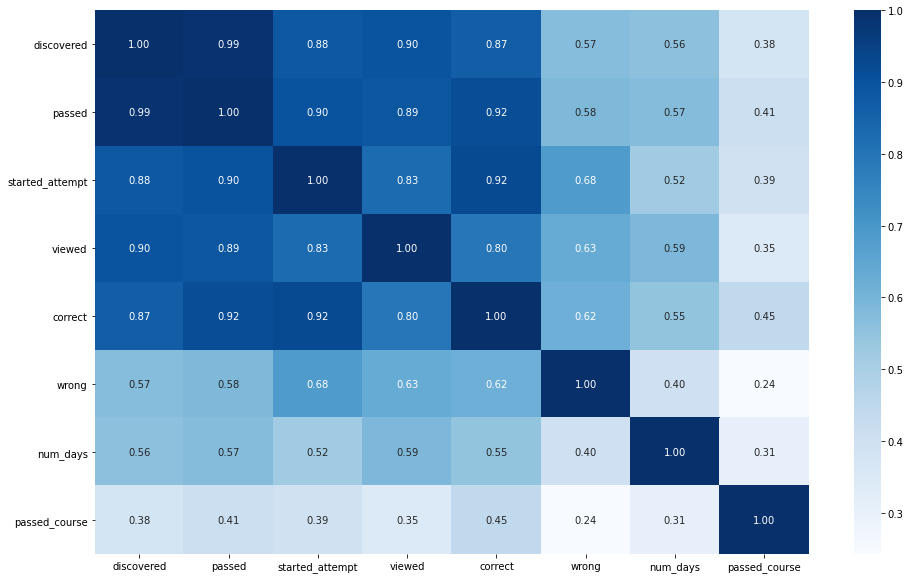

In [97]:
plt.figure(figsize = (16, 10)) 
sns.heatmap(train_df.corr('pearson'), annot=True, fmt='.2f', cmap='Blues');

<Figure size 1152x720 with 0 Axes>

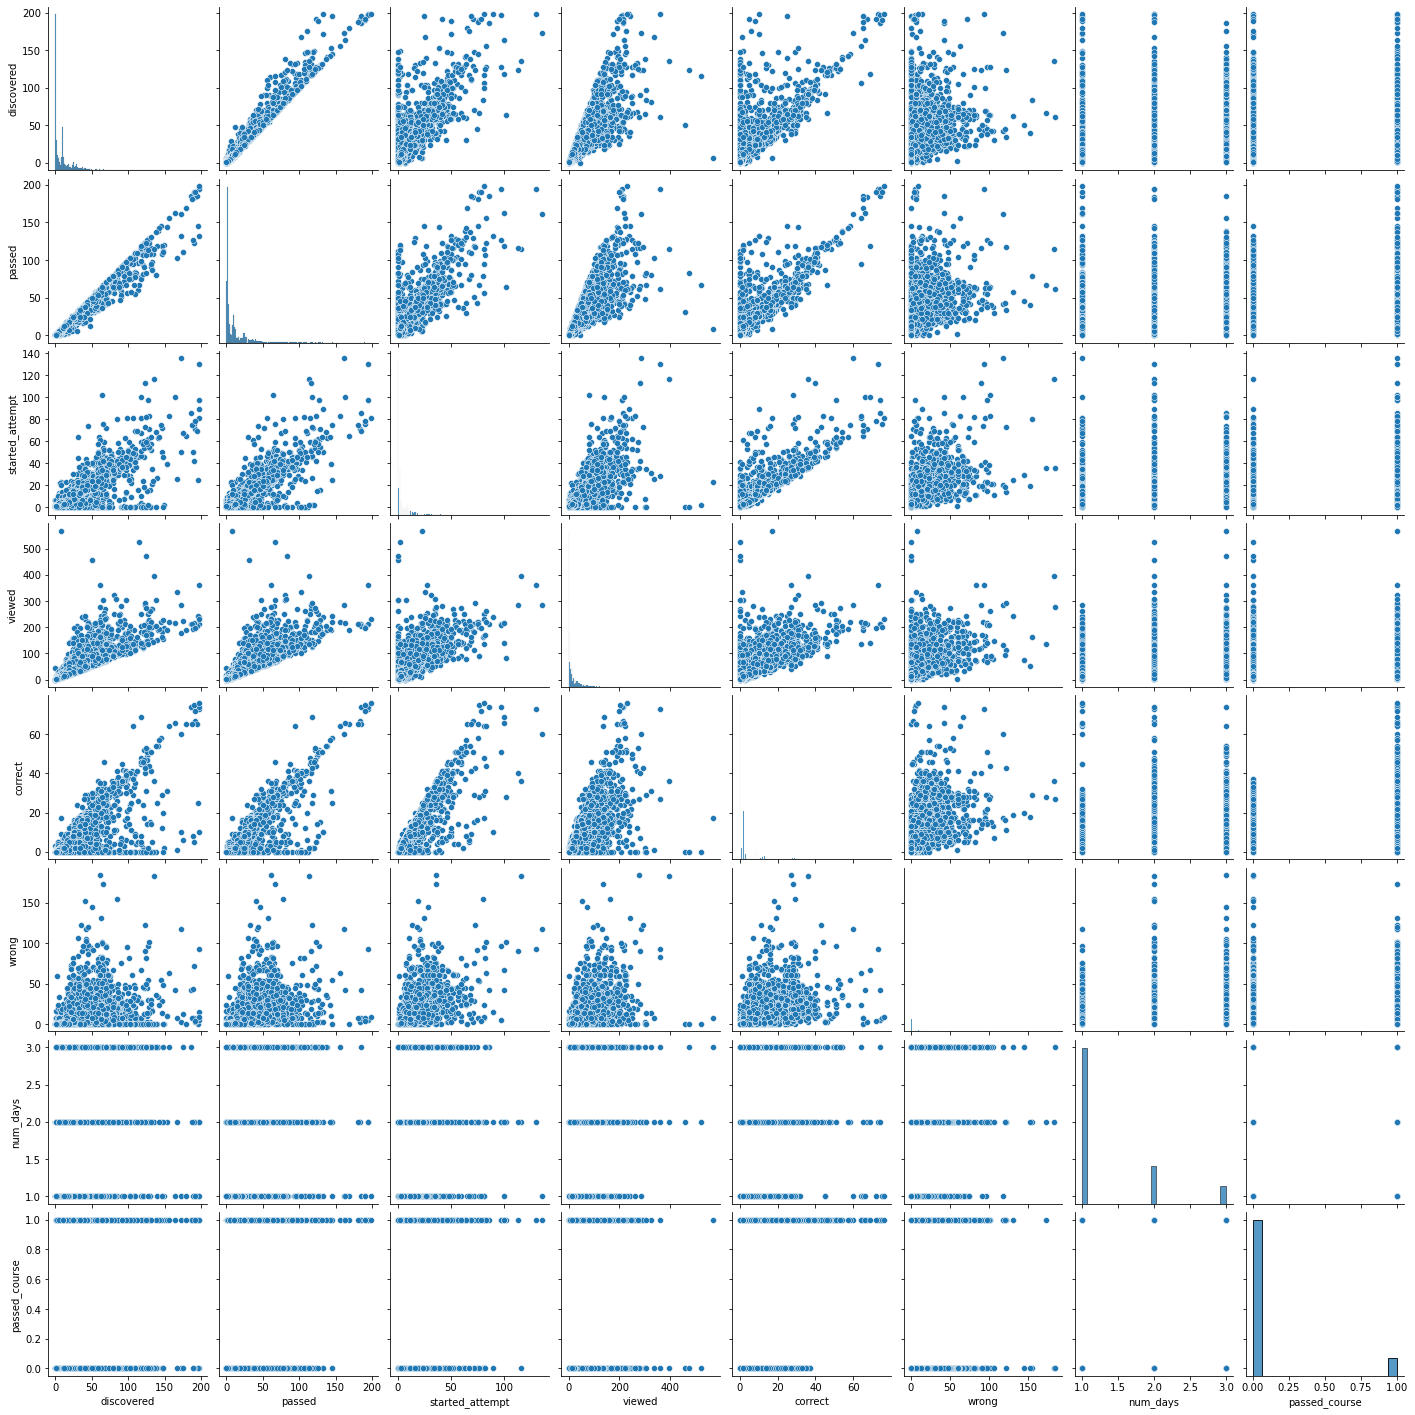

In [98]:
plt.figure(figsize = (16, 10)) 
sns.pairplot(train_df);

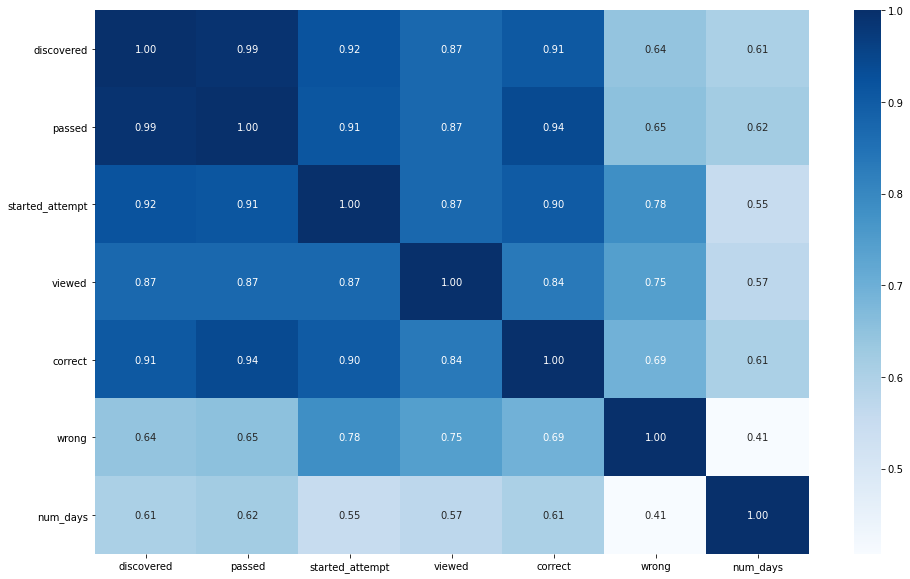

In [99]:
plt.figure(figsize = (16, 10)) 
sns.heatmap(test_df.corr('pearson'), annot=True, fmt='.2f', cmap='Blues');

Все фичи довольно сильно коррелируют. Так как мы древесной моделью это решать собираемся (как предполагается в курсе), то надо хотя бы выкинуть те, у которых попарная корреляция сильная, или нелинейно преобразовать признаки. Посмотрим на графики:

In [100]:
def plot_feature(feature, target_feature='passed_course', df=train_df, plot=sns.countplot, description=None):
    fig, ax = plt.subplots(1, 2, figsize=(13, 8))
    for i in [0, 1]:
        plot(df.loc[df[target_feature] == i, feature], ax=ax[i])
        ax[i].set_title('course' + ' not' * (1 - i) + ' passed')

    if description is None:    
        plt.suptitle(f'Distribution of {feature} according to the target feature')
    else:
        plt.suptitle(description);

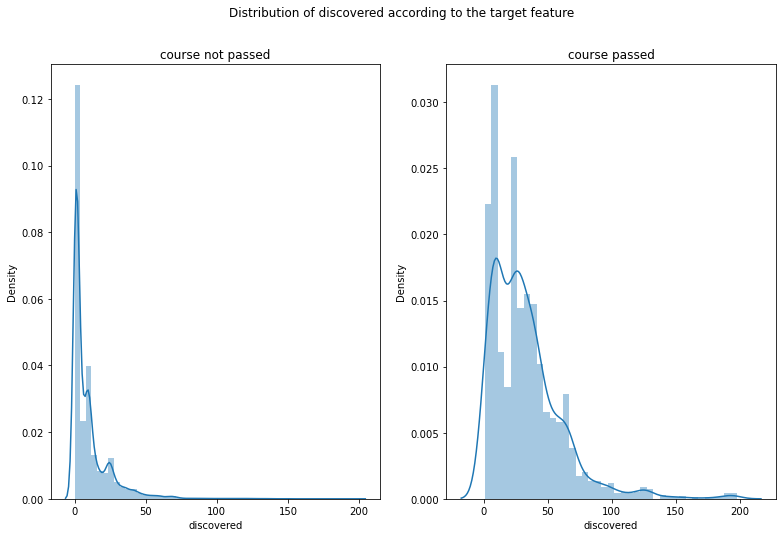

In [101]:
plot_feature('discovered', plot=sns.distplot)

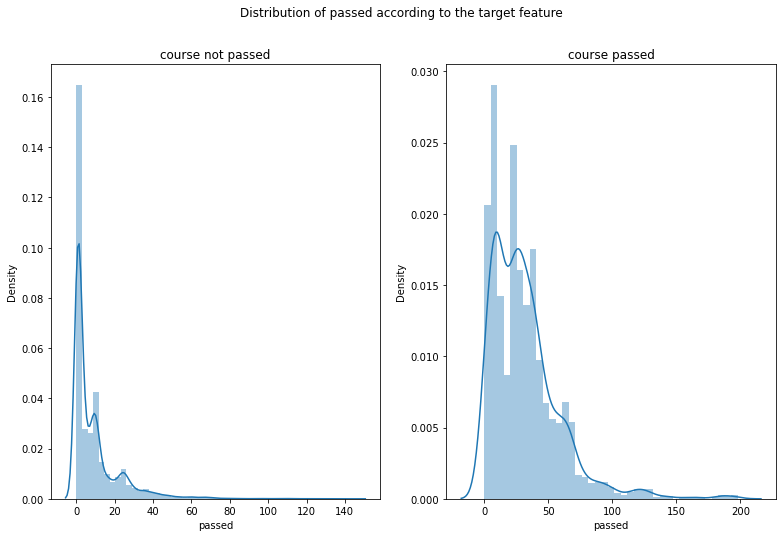

In [102]:
plot_feature('passed', plot=sns.distplot)

# Поиск аномалий в базовых признаках

Бывает ли passed больше одного раза на степ для юзера?

In [103]:
events.query('action == "passed"').groupby(['user_id', 'step_id']).timestamp.count().value_counts()

1    650331
Name: timestamp, dtype: int64

In [104]:
events_test.query('action == "passed"').groupby(['user_id', 'step_id']).timestamp.count().value_counts()

1    62357
Name: timestamp, dtype: int64

Не бывает, хоть это хорошо. И ```discovered``` тоже не бывает. Для не-задач не бывает действий ```started_attempt```, это хорошо:

In [105]:
events[events.step_id.isin(non_problem_steps)].groupby('action').timestamp.count()

action
discovered     433889
passed         433889
viewed        1117742
Name: timestamp, dtype: int64

In [106]:
events_test[events_test.step_id.isin(non_problem_steps)].groupby('action').timestamp.count()

action
discovered    45194
passed        45194
viewed        77439
Name: timestamp, dtype: int64

## Аномалии с признаками задач

Попробуем поискать пользователей с аномальными сочетаниями значений признаков в базовой таблице. Например, почти всегда решение задачи начинается с ивента ```started_attempt```, но есть и случаи, для которых ```started_attempt = 0```, но при этом были попытки решить задачу:

In [107]:
problem_column_order = ['discovered', 'passed', 'started_attempt', 'viewed', 'correct', 'wrong']


def get_actions_by_user_and_step(actions_df, steps_subset=problem_steps, column_order=problem_column_order):
    """Посчитать количество действий с разбивкой по юзерам и степам"""
    
    actions_by_user_and_step = actions_df[actions_df.step_id.isin(steps_subset)].pivot_table(
    index=['user_id', 'step_id'],
    columns='action',
    values='timestamp',
    aggfunc='count',
    fill_value=0,
    )
    
    actions_by_user_and_step = actions_by_user_and_step[column_order]
    return actions_by_user_and_step


problem_actions_user_step = get_actions_by_user_and_step(all_actions)
problem_actions_user_step_2d = get_actions_by_user_and_step(all_actions_2d)
problem_actions_user_step_test = get_actions_by_user_and_step(all_actions_test)

problem_actions_user_step.head()

action           discovered  passed  started_attempt  viewed  correct  wrong
user_id step_id                                                             
1       31981             1       0                0       1        0      0
2       32812             1       1                1       1        1      0
        32929             1       1                1       1        1      0
3       31971             1       1                1       2        1      0
        31972             1       1                1       1        1      0

In [108]:
problem_actions_user_step.query('started_attempt == 0 & ((correct + wrong > 0) | (passed > 0))')

action           discovered  passed  started_attempt  viewed  correct  wrong
user_id step_id                                                             
1046    32175             0       0                0      52        0      1
        32810             0       1                0      31        1      0
        32929             0       1                0      38        1      0
1078    32190             0       1                0      17        1      0
11582   32219             0       1                0       2        1      0
19286   32089             0       1                0       1        1      0

Видим также, что у этих пользователей и степов стоит 0 в графе ```discovered```, чего тоже быть не должно. Посмотрим на это потом.

In [109]:
problem_actions_user_step_2d.query('started_attempt == 0 & ((correct + wrong > 0) | (passed > 0))')

action           discovered  passed  started_attempt  viewed  correct  wrong
user_id step_id                                                             
1046    31977             0       0                0      24        1      0
        32810             0       1                0       6        1      0

В выборке за 2 дня остается только ```user_id = 1046```, запомним его как выброс. Причем появляется новый степ, то есть, на самом деле надо проверять (группируя по степам) ```correct```, ```wrong``` или ```passed```, идущие перед ```started_attempt```. Но это как-то сложно пока что.

In [110]:
outlier_users = [1046]

В тестовой выборке аналогичных аномалий нет:

In [111]:
problem_actions_user_step_test.query('started_attempt == 0 & ((correct + wrong > 0) | (passed > 0))')

,action,discovered,passed,started_attempt,viewed,correct,wrong
user_id,step_id,,,,,,


Проверим также аномальные сочетания ```passed == 0 & correct > 0``` и ```passed > 0 & correct == 0```:

In [112]:
problem_actions_user_step_2d.query('passed == 0 & correct > 0') # для all_actions то же самое выдает

action           discovered  passed  started_attempt  viewed  correct  wrong
user_id step_id                                                             
1046    31971             0       0                1      14        1      0
        31972             0       0                1      20        1      0
        31976             0       0                3      30        2      1
        31977             0       0                0      24        1      0
        31979             0       0                5      18        4      1
        31981             0       0                1      12        1      0
        31983             0       0                2      23        1      1
        32031             0       0                1      15        1      0
        32173             0       0                1       9        1      0
        32174             0       0                1      12        1      0
        32244             0       0                2      17        1      1
1078    32202             0       0                2       4        2      1
4762    32244             0       0                3       6        3      3

Добавим ```user_id = 1078, 4762``` в выбросы тоже (они и по другим признакам будут аномальными, см. ниже).

In [113]:
outlier_users += [1078, 4762]

In [114]:
problem_actions_user_step_test.query('passed == 0 & correct > 0')

,action,discovered,passed,started_attempt,viewed,correct,wrong
user_id,step_id,,,,,,


In [115]:
problem_actions_user_step.query('passed > 0 & correct == 0') 

,action,discovered,passed,started_attempt,viewed,correct,wrong
user_id,step_id,,,,,,


In [116]:
problem_actions_user_step_test.query('passed > 0 & correct == 0') 

action           discovered  passed  started_attempt  viewed  correct  wrong
user_id step_id                                                             
19480   31971             1       1                1       1        0      0
        31972             1       1                1       1        0      0
        31976             1       1                1       1        0      0
        31977             1       1                2       1        0      0
        31978             1       1                2       2        0      0
        32219             1       1                1       1        0      0
        32812             1       1                1       1        0      0
        32929             1       1                2       1        0      0
        120745            1       1                1       1        0      0

А вот тут внезапно один поломанный юзер в тесте. Но одного можно пережить, пожалуй. А вот примеров когда человек начал решать задачу и не сделал ни одного сабмита много:

In [117]:
problem_actions_user_step.query('started_attempt > 0 & (correct + wrong == 0)')

action           discovered  passed  started_attempt  viewed  correct  wrong
user_id step_id                                                             
8       31988             1       0                1       2        0      0
        32190             1       0                1       1        0      0
        32809             1       0                1       1        0      0
        32810             1       0                1       1        0      0
        33351             1       0                1       1        0      0
...                     ...     ...              ...     ...      ...    ...
26786   32812             1       0                1       3        0      0
26787   32031             1       0                1       1        0      0
        32173             1       0                1       1        0      0
        32174             1       0                1       1        0      0
26793   31976             1       0                1       1        0      0

[16095 rows x 6 columns]

## Аномалии с ```discovered``` и ```viewed```

Теперь посмотрим на аномалии, связанные с ```discovered``` и ```viewed``` (по идее, если пользователь хоть как-то взаимодействовал со степом, то должны быть и эти взаимодействия), и для не задачных степов тоже.

In [118]:
non_problem_column_order = ['discovered', 'passed', 'viewed']

non_problem_actions_user_step = get_actions_by_user_and_step(events, non_problem_steps, non_problem_column_order)
non_problem_actions_user_step_2d = get_actions_by_user_and_step(events_2d, non_problem_steps, non_problem_column_order)
non_problem_actions_user_step_test = get_actions_by_user_and_step(events_test, non_problem_steps, non_problem_column_order)

non_problem_actions_user_step.head()

action           discovered  passed  viewed
user_id step_id                            
2       32811             1       1       1
        32814             1       1       1
        32815             1       1       1
        32816             1       1       1
        32927             1       1       2

In [119]:
non_problem_actions_user_step.query('discovered != passed')

,action,discovered,passed,viewed
user_id,step_id,,,


In [120]:
non_problem_actions_user_step_test.query('discovered != passed')

,action,discovered,passed,viewed
user_id,step_id,,,


То есть, для не-задач ```discovered = passed```, как и должно быть

Аномалиями также будут являться пары (юзер, степ), для которых ```discovered = 0```, но ```viewed``` или какое-нибудь другое действие не равны 0. А сколько вообще таких пар? Проверим отдельно для задачных и не задачных степов.

In [121]:
undiscovered_non_problems_train = non_problem_actions_user_step_2d.query('discovered == 0')
undiscovered_non_problems_train

action           discovered  passed  viewed
user_id step_id                            
1046    31955             0       0       8
        31956             0       0       6
        31957             0       0       4
        31958             0       0       3
        31959             0       0       3
...                     ...     ...     ...
22419   32815             0       0       1
23394   31956             0       0       1
23577   32243             0       0       1
23609   32187             0       0       1
24244   32814             0       0       2

[83 rows x 3 columns]

In [122]:
undiscovered_non_problems_train.reset_index().user_id.value_counts()

1046     32
12133    13
4762     10
20907     7
1078      5
7383      3
18917     2
19635     1
22419     1
23577     1
8063      1
24244     1
23609     1
8251      1
19286     1
12894     1
23394     1
18619     1
Name: user_id, dtype: int64

In [123]:
undiscovered_non_problems_train.reset_index().step_id.value_counts().head(10)

32191    9
31956    6
32176    5
32815    4
31955    4
31957    3
32927    3
32195    3
32187    3
31958    3
Name: step_id, dtype: int64

Видно, что на некоторых юзерах и степах все записывается хуже (на других, видимо, просто случайность, хотя не очень понятно, как это не на глаз определять). Для тестовой выборки аналогичной проблемы не возникает:

In [124]:
non_problem_actions_user_step_test.query('discovered == 0')

,action,discovered,passed,viewed
user_id,step_id,,,


Наверно, надо зачистить данные в тренировочной выборке о юзерах и / или степах с такими проблемами, или руками поправить тренировочные данные. И нет не задачных степов таких, что ```viewed = 0``` (в тестовой выборке тоже нет):

In [125]:
non_problem_actions_user_step_2d.query('viewed == 0')

,action,discovered,passed,viewed
user_id,step_id,,,


Аналогичная аномалия с задачными степами более распространена:

In [126]:
undiscovered_problems_train = problem_actions_user_step_2d.query('discovered == 0')
undiscovered_problems_train

action           discovered  passed  started_attempt  viewed  correct  wrong
user_id step_id                                                             
76      31991             0       0                1       0        0      0
        32175             0       0                1       0        0      0
        32190             0       0                1       0        0      0
        33351             0       0                1       0        0      0
        33362             0       0                1       0        0      0
...                     ...     ...              ...     ...      ...    ...
26498   32219             0       0                1       0        0      0
26502   32206             0       0                1       0        0      0
26511   32812             0       0                1       0        0      0
26530   31971             0       0                1       0        0      0
26612   32812             0       0                1       0        0      0

[595 rows x 6 columns]

Примеры задачных (и не задачных тоже) степов без ```discovered``` появляются, в отличие от тестовой выборки, не только в конце всей истории действий пользователя (можно убрать указание степа и проверить).

In [127]:
all_actions_2d.query('user_id == 26498 & step_id == 32219')

,step_id,timestamp,action,user_id,time
2977406,32219,1512635117,started_attempt,26498,2017-12-07 08:25:17


In [128]:
undiscovered_problems_train.sum(axis=0)

action
discovered           0
passed             140
started_attempt    615
viewed             502
correct            179
wrong               54
dtype: int64

In [129]:
undiscovered_problems_train.reset_index().user_id.value_counts()

1046     28
1078     17
12133    12
10353    11
10782    11
         ..
18927     1
26411     1
14490     1
23006     1
11710     1
Name: user_id, Length: 306, dtype: int64

In [130]:
undiscovered_problems_train.reset_index().step_id.value_counts().head(10)

32812     100
32929      99
32219      38
31977      23
31971      22
31972      18
31976      17
120745     15
31978      15
31991      12
Name: step_id, dtype: int64

Видим, что на каких-то степах и на каких-то пользователях чаще не логируется, чем на других. 306 пользователей — это слишком много, чтобы удалять руками. Тем более что аналогичные аномалии и в тестовой выборке тоже есть:

In [131]:
undiscovered_problems_test = problem_actions_user_step_test.query('discovered == 0')
undiscovered_problems_test

action           discovered  passed  started_attempt  viewed  correct  wrong
user_id step_id                                                             
12      32219             0       0                1       0        0      0
167     32812             0       1                1       0        1      0
        32929             0       1                1       0        1      0
298     31976             0       0                1       0        0      0
421     32202             0       0                1       0        0      0
...                     ...     ...              ...     ...      ...    ...
25674   31972             0       0                1       0        0      0
25740   32219             0       0                1       0        0      0
        32812             0       0                1       0        0      0
26232   32812             0       0                1       0        0      0
26368   32812             0       0                1       0        0      0

[266 rows x 6 columns]

In [132]:
undiscovered_problems_test.reset_index().user_id.value_counts()

9134     8
23754    6
21524    6
3609     5
24292    4
        ..
22334    1
23350    1
10549    1
2863     1
25062    1
Name: user_id, Length: 203, dtype: int64

In [133]:
undiscovered_problems_test.reset_index().step_id.value_counts().head(10)

32929     41
32812     38
32219     31
31977     13
120745    13
31976     12
31972     10
32175     10
32173      9
32174      7
Name: step_id, dtype: int64

То есть и в тесте, и в трейне примерно те же степы плохо регистрируются, но в тесте нет пользователей, у которых бы логирование не срабатывало чаще (скорей всего, пользователи из тренировочной выборки, для которых логирование не работает чаще, являются модераторами курса и могут проходить курс не так, как обычные пользователи, так что их лучше исключить из тренировочного множества).

In [134]:
undiscovered_problems_test.sum(axis=0)

action
discovered           0
passed               9
started_attempt    269
viewed               0
correct              9
wrong                1
dtype: int64

То есть в тестовой выборке нет задачных степов с ```discovered = 0, viewed > 0```. Если такого вида ошибок записи в тестовой выборке нет, то, наверное, лучше избавиться от таких и в обучающей.

In [135]:
all_actions_test.query('user_id == 25674').tail()

,step_id,timestamp,action,user_id,time
102601,31976,1544530314,discovered,25674,2018-12-11 12:11:54
102594,31959,1544530314,viewed,25674,2018-12-11 12:11:54
102598,31976,1544530314,viewed,25674,2018-12-11 12:11:54
102597,31972,1544530315,started_attempt,25674,2018-12-11 12:11:55
102599,31976,1544530345,viewed,25674,2018-12-11 12:12:25


Можно заметить, что отсутствие ```viewed``` и ```discovered``` для задач в тестовой выборке получается только если взаимодействие с задачей произошло под самый конец активности пользователя. Посмотрим на задачи из тренировочной выборки с ```viewed = 0```:

In [136]:
unviewed_problems_train = problem_actions_user_step_2d.query('viewed == 0')
unviewed_problems_train

action           discovered  passed  started_attempt  viewed  correct  wrong
user_id step_id                                                             
76      31991             0       0                1       0        0      0
        32175             0       0                1       0        0      0
        32190             0       0                1       0        0      0
        33351             0       0                1       0        0      0
        33362             0       0                1       0        0      0
...                     ...     ...              ...     ...      ...    ...
26498   32219             0       0                1       0        0      0
26502   32206             0       0                1       0        0      0
26511   32812             0       0                1       0        0      0
26530   31971             0       0                1       0        0      0
26612   32812             0       0                1       0        0      0

[503 rows x 6 columns]

In [137]:
unviewed_problems_train.reset_index().user_id.value_counts()

10353    11
10782    11
20997    10
2261      9
7582      7
         ..
14186     1
11046     1
11357     1
16673     1
767       1
Name: user_id, Length: 292, dtype: int64

In [138]:
unviewed_problems_train.reset_index().step_id.value_counts()

32812    98
32929    97
32219    34
31977    17
31971    17
         ..
33439     1
33992     1
33983     1
33684     1
33413     1
Name: step_id, Length: 66, dtype: int64

In [139]:
unviewed_problems_train.sum(axis=0)

action
discovered           0
passed             128
started_attempt    567
viewed               0
correct            141
wrong               38
dtype: int64

Видим, что ```viewed = 0 => discovered = 0```. Здесь уже нет юзеров, для которых бы это действие не фиксировалось чаще, чем для остальных, а степы, на которых не фиксируется действие, те же, что и раньше. В отличие от тестовой выборки, бывают степы с ```discovered = 0, viewed > 0```.

In [140]:
undiscovered_viewed_problems_train = undiscovered_problems_train.query('viewed != 0')
undiscovered_viewed_problems_train

action           discovered  passed  started_attempt  viewed  correct  wrong
user_id step_id                                                             
1046    31971             0       0                1      14        1      0
        31972             0       0                1      20        1      0
        31976             0       0                3      30        2      1
        31977             0       0                0      24        1      0
        31978             0       0                0      25        0      0
...                     ...     ...              ...     ...      ...    ...
20907   32244             0       0                0       1        0      0
22419   31971             0       0                0       1        0      0
        32031             0       0                0       1        0      0
23577   31991             0       0                0       2        0      0
        32173             0       0                0       1        0      0

[92 rows x 6 columns]

In [141]:
undiscovered_viewed_problems_train.reset_index().user_id.value_counts()

1046     28
1078     17
12133    12
20907     8
4762      8
7383      3
19286     3
18619     3
12894     2
18906     2
23577     2
22419     2
16145     1
12036     1
Name: user_id, dtype: int64

In [142]:
undiscovered_viewed_problems_train.reset_index().step_id.value_counts().head(10)

31972    7
31977    6
31978    5
31976    5
31971    5
32206    5
32244    4
32031    4
32219    4
32202    3
Name: step_id, dtype: int64

И что тут? Получается, опять все те же плохие юзеры и нет системы по степам.

Что можно сделать с этими аномалиями? Понятно, что работай мы в степике, надо было бы чинить логгер, тем более, что видно в какие моменты он чаще ломается. Но у нас только датасет на руках, так что остается его руками поправить, что и сделаем в конце этой тетрадки. А пользователей, для которых чаще всего проявлялись аномалии выше, будем рассматривать как выбросы (и в итоге выбросим из тренировочного множества):

In [143]:
outlier_users += [2261, 10353, 10782, 12133, 20907, 20997]

## Аномалии с количеством действий за единицу времени

Еще можно поискать аномалии по количеству действий в среднем в секунду, минуту и так далее. Посмотрим, сколько действий вообще совершают пользователи и сколько уникальных моментов времени они проводят на курсе.

In [144]:
users_action_counts = all_actions_2d.groupby('user_id').action.count()

In [145]:
users_action_counts.describe()

count    19234.000000
mean        53.117864
std         83.991379
min          1.000000
25%          3.000000
50%         20.000000
75%         63.000000
max       1050.000000
Name: action, dtype: float64

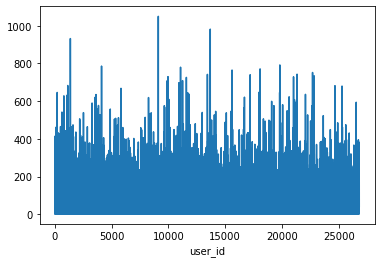

In [146]:
users_action_counts.plot();

In [147]:
users_timestamp_counts = all_actions_2d.groupby('user_id').timestamp.nunique()

Понятно, что это очень коррелирующие вещи должны быть.

In [148]:
sps.pearsonr(users_action_counts, users_timestamp_counts)

(0.9834268367667389, 0.0)

А вот отношение посмотреть интересно: оно выражает, сколько в среднем в секунду выполняется действий пользователями. В обычной ситуации должно быть 2-3(```passed```, ```viewed``` и ```discovered``` для не-задач наступают одновременно и так далее).

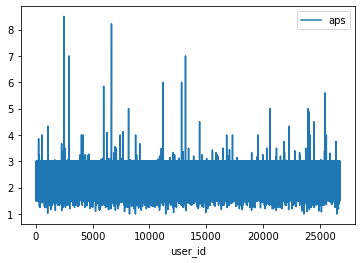

In [149]:
users_actions_per_second = pd.DataFrame(users_action_counts/ users_timestamp_counts).rename(columns={0:'aps'})
del users_action_counts, users_timestamp_counts
users_actions_per_second.plot();

Вот тут отчетливо видно выбросы, да.

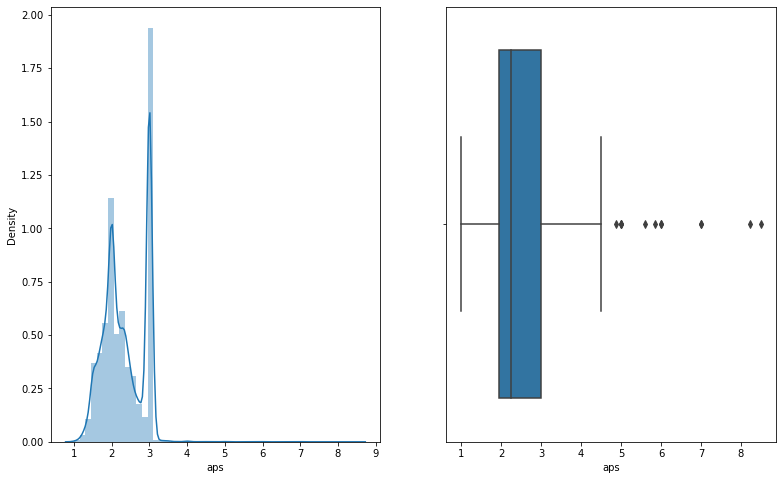

In [150]:
_, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.distplot(users_actions_per_second.aps, ax = ax[0])
sns.boxplot(users_actions_per_second.aps, ax = ax[1]);

In [151]:
users_actions_per_second.quantile(q=0.99)

aps    3.0
Name: 0.99, dtype: float64

In [152]:
users_actions_per_second.query('aps > 3')

,aps
user_id,
247,3.032258
249,3.857143
311,3.250000
537,4.000000
1069,4.333333
...,...
25421,3.400000
25469,5.600000
25580,4.000000


In [153]:
users_actions_per_second.max(), users_actions_per_second.idxmax() 

(aps    8.5
 dtype: float64,
 aps    2481
 dtype: int64)

In [154]:
all_actions_2d.query('user_id == 2481').shape[0],\
all_actions_2d.query('user_id == 2481').timestamp.nunique(),\
all_actions_2d.query('user_id == 2481').step_id.nunique()

(51, 6, 20)

Видно, что в тренировочной выборке много ошибок, когда действия логируются на одно время (можно сгруппировать действия по пользователям и таймстемпам и увидеть это еще раз). В тестовой ситуация аналогичная, можно посмотреть в скрытых клетках.

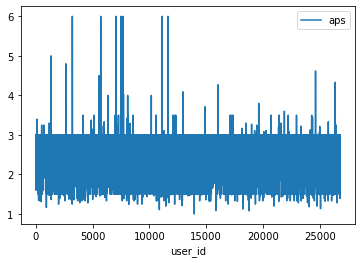

In [155]:
users_action_counts_test = all_actions_test.groupby('user_id').action.count()
users_timestamp_counts_test = all_actions_test.groupby('user_id').timestamp.nunique()
users_actions_per_second_test = pd.DataFrame(users_action_counts_test / 
                                             users_timestamp_counts_test).rename(columns={0:'aps'})
del users_action_counts_test, users_timestamp_counts_test
users_actions_per_second_test.plot();

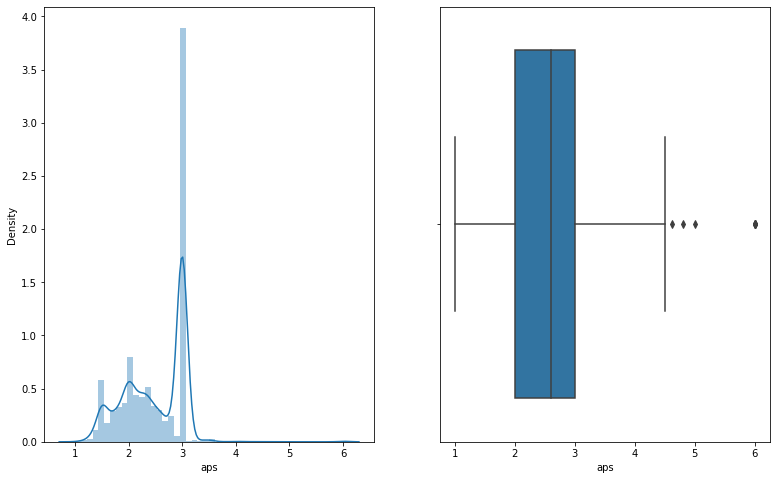

In [156]:
fig, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.distplot(users_actions_per_second_test.aps, ax = ax[0])
sns.boxplot(users_actions_per_second_test.aps, ax = ax[1]);

In [157]:
users_actions_per_second_test.quantile(q=0.97)

aps    3.0
Name: 0.97, dtype: float64

In [158]:
users_actions_per_second_test.max(), users_actions_per_second_test.idxmax() 

(aps    6.0
 dtype: float64,
 aps    3221
 dtype: int64)

In [159]:
users_actions_per_second_test.query('aps > 3')

,aps
user_id,
105,3.400000
522,3.250000
733,3.250000
1192,3.300000
1357,5.000000
...,...
25004,3.214286
25757,3.333333
25904,3.015625


Было бы хорошо рассматривать действия пользователей как временной ряд, но для этого надо, чтобы хоть на каком-то масштабе нам не мешали баги в логере. Давайте попробуем группировать по разным промежуткам времени и смотреть, на каком масштабе аномальные скачки активности в одну секунду будут не так заметны (а как это замерять? на глаз — что очень сильных выбросов не очень много), и при этом чтобы промежутки были не сильно короткими, потому что иначе будет очень много периодов с нулевой активностью (так что будем измерять в часах).

In [280]:
def show_actions_by_period(actions_df, period_len):
    """
    Выдать базовые статистики активности по периодам длиной period_len часов
    за TOTAL_DAYS дней начиная от начала активности
    
    Parameters
    ----------
    actions_df : pd.DataFrame
        Таблица с действиями пользователей
    period_len : int
        Длина (в часах) периода, на котором агрегируем действия пользователей
        
    Returns
    -------
    actions_by_period : pd.Series
        Таблица с количеством действий пользователей по периодам,
        отсортированная по убыванию
    """
    
    actions_by_period, actions_with_periods = \
        get_action_counts_by_period(actions_df, period_len, sum_only=True, drop_periods=False)
    
    record_num_actions = actions_by_period.max().item()
    record_user_id, record_period = actions_by_period.idxmax().item()
    record_period = record_period.split('_')[0] # оставляем только название самого периода
    record_num_steps = actions_with_periods.query('user_id == @record_user_id & period == @record_period').step_id.nunique()
    zero_activity_periods_share = actions_by_period.value_counts(normalize=True)[0].item()
    print(f'Maximum actions by {period_len}H: {record_num_actions}')
    print(f'Maximum number of steps visited during {period_len}H: {record_num_steps}')
    print(f'Share of periods with zero activity: {zero_activity_periods_share:.3f}')
    actions_by_period_values = actions_by_period.to_numpy().flatten()
    
    _, ax = plt.subplots(1, 2, figsize=(13, 8))
    sns.distplot(actions_by_period, ax = ax[0])
    sns.boxplot(actions_by_period_values, ax = ax[1]);
    
    q_25, q_50, q_75 = np.quantile(actions_by_period_values, [0.25, 0.5, 0.75]).tolist()
    print(f'Median actions by {period_len}H: {q_50}')
    
    outliers_share = (actions_by_period_values > q_50 + 1.5 * (q_75 - q_25)).sum() / actions_by_period_values.shape[0]
    print(f'Share of outliers: {round(outliers_share, 3)}')
    
    return actions_by_period.sort_values(by='action', ascending=False)

Можно попробовать поставить разные значения периодов в ячейке снизу:

Maximum actions by 24H: 1050
Maximum number of steps visited during 24H: 198
Share of periods with zero activity: 0.404
Median actions by 24H: 3.0
Share of outliers: 0.166


,action
0.50,3.0
0.99,251.0


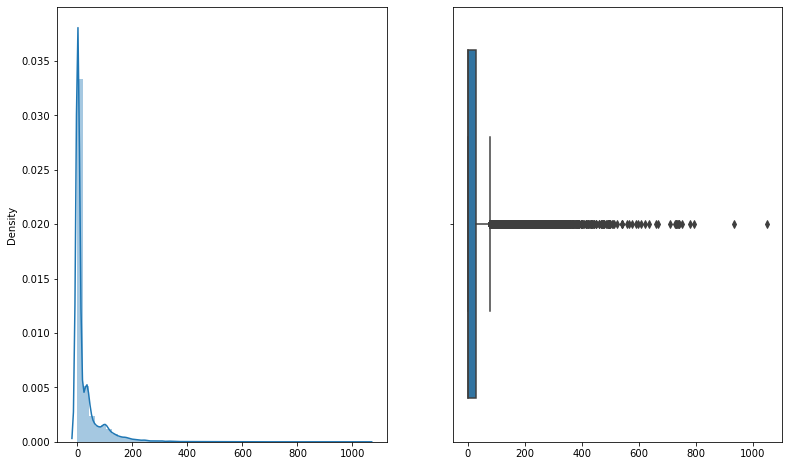

In [161]:
show_actions_by_period(all_actions_2d, period_len=24).quantile([0.5, 0.99])

Видимо, усреднение по суткам самое адекватное. В тестовой выборке аналогичная ситуация:

Maximum actions by 24H: 745
Maximum number of steps visited during 24H: 68
Share of periods with zero activity: 0.414
Median actions by 24H: 3.0
Share of outliers: 0.195


,,action
user_id,,
4593,0-24H_actions,745
21396,0-24H_actions,690
1359,0-24H_actions,662
26775,0-24H_actions,655
14978,0-24H_actions,651
...,...,...
17942,24-48H_actions,0
7880,24-48H_actions,0
17940,24-48H_actions,0


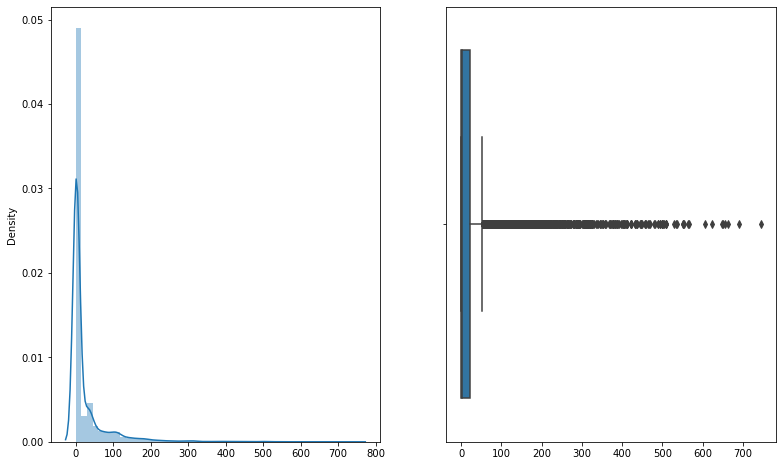

In [162]:
show_actions_by_period(all_actions_test, period_len=24)

Только здесь нет таких выраженных двух выбросов, как в тренировочной выборке. Скорей всего потому, что выборка поменьше. Но можно и выкинуть две строчки, не обеднеем сильно.

In [163]:
outlier_users += [9104, 1361]

## Аномалии с общим количеством действий

Давайте посмотрим, какие пользователи имеют больше отметок по тем или иным действиям (если действий слишком много, то либо опять произошел баг логера, либо пользователь является модератором, которых бы лучше выкинуть, так как они явно не являются типичными пользователями). За два дня тенденции будут видны не сильно, так что можно будет посмотреть данные о действиях из всей тестовой выборки (даже если пользователь не ведет себя аномально в течение двух дней согласно простым признакам, на которые мы смотрим сейчас, то он может быть аномалией по каким-нибудь другим признакам).

Отсортируем пользователей по общему количеству корректных решений и посмотрим, нет ли выбросов:

In [164]:
train_df_all.sort_values(by='correct', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
1046,128,124,721,8122,421,513,478,1
5552,198,198,224,1141,186,93,56,1
17135,196,196,190,1040,168,177,31,1
6183,196,196,150,758,142,65,39,1
8461,198,198,154,977,135,42,25,1
1218,198,198,162,626,130,71,24,1
14699,196,196,128,678,121,33,13,1
24022,194,194,148,621,121,118,49,1
30,198,198,150,512,119,79,42,1


In [165]:
train_df_all.correct.quantile(0.99)

79.0

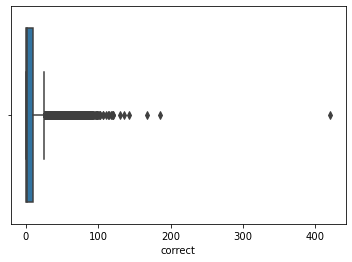

In [166]:
sns.boxplot(train_df_all.correct);

Опять можем отсеять ```user_id = 1046```. А в данных за два дня что?

In [167]:
train_df.sort_values(by='correct', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
19805,198,198,81,230,76,9,1,1
17191,190,190,76,202,75,7,1,1
4106,186,185,86,213,74,42,3,1
11061,197,195,97,212,74,5,2,1
9104,198,195,130,361,73,93,2,1
22833,192,190,78,198,72,4,1,1
22713,118,118,100,138,69,67,2,1
9956,192,184,71,213,67,3,2,1
22684,164,163,100,217,66,42,1,1


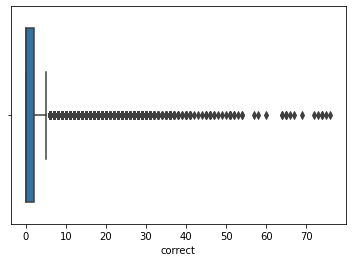

In [168]:
sns.boxplot(train_df.correct);

In [169]:
test_df.sort_values(by='correct', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
user_id,,,,,,,
26775,113,103,84,455,46,160,3
18602,73,72,57,215,43,68,3
9788,121,113,74,437,42,128,2
11619,121,111,64,543,42,62,3
13550,121,108,66,391,41,92,2
21685,151,135,56,151,40,0,1
21444,123,117,71,129,40,1,1
4254,102,99,52,388,40,88,3
19796,105,103,51,292,40,17,3


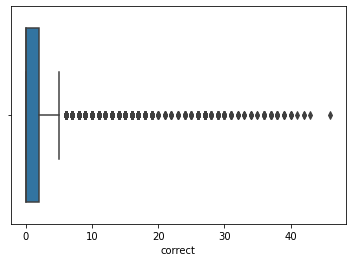

In [170]:
sns.boxplot(test_df.correct);

Здесь очевидных выбросов не видно (а как это проверять не на глаз?). Опять видим, что распределения показателей ```correct``` в тренировочной и тестовой выборках отличаются (скорее всего потому, что тренировочная выборка просто больше).

Отсортируем по значению ```wrong```:

In [171]:
train_df_all.sort_values(by='wrong', ascending=False).head()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
12265,156,127,178,782,50,1001,15,1
3643,198,198,160,1388,81,867,41,1
20236,162,144,129,481,51,830,4,1
14454,197,192,171,1259,98,822,44,1
643,195,195,101,985,76,812,50,1


In [172]:
all_actions.query('user_id == 12265 & action == "wrong"').step_id.value_counts().head()

33351    280
32198    156
33669     58
32089     58
33684     34
Name: step_id, dtype: int64

In [173]:
all_actions.query('user_id == 12265 & step_id == 33351 & action == "wrong"').head(10)

,step_id,timestamp,action,user_id,time
482586,33351,1524912117,wrong,12265,2018-04-28 10:41:57
482587,33351,1524912129,wrong,12265,2018-04-28 10:42:09
482588,33351,1524912137,wrong,12265,2018-04-28 10:42:17
482589,33351,1524912146,wrong,12265,2018-04-28 10:42:26
482590,33351,1524912158,wrong,12265,2018-04-28 10:42:38
482591,33351,1524912169,wrong,12265,2018-04-28 10:42:49
482592,33351,1524912178,wrong,12265,2018-04-28 10:42:58
482593,33351,1524912186,wrong,12265,2018-04-28 10:43:06
482594,33351,1524912194,wrong,12265,2018-04-28 10:43:14
482595,33351,1524912236,wrong,12265,2018-04-28 10:43:56


Просто какие-то люди решают задачи перебором, ну ок. Отсортируем по значению ```viewed```:

In [174]:
train_df_all.sort_values(by='viewed', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
20907,163,102,0,32778,0,0,221,0
10794,198,122,27,16089,0,0,281,0
25279,198,122,166,9693,0,0,75,0
1046,128,124,721,8122,421,513,478,1
3572,194,193,550,6968,113,398,236,1
11770,193,118,0,6330,0,0,57,0
9546,192,119,161,5915,0,0,108,0
761,193,118,0,4281,0,0,43,0
8363,194,119,113,3492,0,0,48,0


Странные юзеры, у которых много ```viewed```, но при этом ни одного сабмита... 

In [175]:
train_df_all.query('correct + wrong == 0').sort_values(by='viewed', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
20907,163,102,0,32778,0,0,221,0
10794,198,122,27,16089,0,0,281,0
25279,198,122,166,9693,0,0,75,0
11770,193,118,0,6330,0,0,57,0
9546,192,119,161,5915,0,0,108,0
761,193,118,0,4281,0,0,43,0
8363,194,119,113,3492,0,0,48,0
6764,193,118,0,2960,0,0,33,0
19472,194,119,0,2738,0,0,73,0


In [176]:
train_df_all.viewed.quantile(0.99)

899.6699999999983

И в данных за два дня такого поведения тоже много:

In [177]:
train_df.sort_values(by='viewed', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
1046,7,8,23,568,17,8,3,1
9880,115,67,2,524,0,0,2,0
25279,124,83,0,473,0,0,3,0
2514,50,31,0,458,0,0,2,0
13678,136,114,116,397,36,183,2,0
9104,198,195,130,361,73,93,2,1
8242,61,61,28,359,27,83,3,0
11792,167,102,26,335,1,7,2,0
3807,81,80,31,323,31,13,3,1


In [178]:
train_df.query('correct + wrong == 0').sort_values(by='viewed', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
9880,115,67,2,524,0,0,2,0
25279,124,83,0,473,0,0,3,0
2514,50,31,0,458,0,0,2,0
19813,97,67,0,305,0,0,2,0
11770,138,80,0,303,0,0,3,0
8363,133,97,35,269,0,0,3,0
22730,130,108,0,262,0,0,1,0
12213,67,41,26,241,0,0,3,0
281,118,108,0,206,0,0,1,0


А в тестовой выборке?

In [179]:
test_df.sort_values(by='viewed', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
user_id,,,,,,,
11619,121,111,64,543,42,62,3
11037,96,90,76,524,35,50,3
25415,102,97,45,473,37,106,3
13385,103,101,64,471,39,56,3
26775,113,103,84,455,46,160,3
9788,121,113,74,437,42,128,2
17982,99,99,49,431,39,35,2
14978,90,89,58,431,36,166,3
7792,105,94,56,416,30,42,3


In [180]:
test_df.query('correct + wrong == 0').sort_values(by='viewed', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
user_id,,,,,,,
12684,103,75,25,336,0,0,2
13746,51,38,12,145,0,0,2
19732,67,59,8,121,0,0,1
15877,97,21,73,121,0,0,1
1831,83,61,22,120,0,0,2
11326,101,101,0,106,0,0,1
10983,46,29,19,84,0,0,1
25271,41,35,6,80,0,0,1
1083,34,27,7,75,0,0,3


In [181]:
test_df.viewed.quantile(0.9)

56.0

Ну по крайней мере не так ярко выражен аналогичный феномен, только один потенциальный "выброс" виден. Сходу не ясно, что делать с такими юзерами. Скажем, что если такое поведение наблюдается только в таблице с данными за первых два дня активности, то такие пользователи только посмотрели теоретический материал и ушли (если показатели ```viewed``` не чересчур велики — опять же, определяем на глаз). А если оно наблюдается и в таблице с полными данными об активности, то это уже не типичные пользователи (хотя опять же, кто-то может использовать курс просто как методичку — у таких, наверно, и ```started_attempt``` должны быть маленькими).

In [182]:
train_df_all.sort_values(by='started_attempt', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
1046,128,124,721,8122,421,513,478,1
3572,194,193,550,6968,113,398,236,1
8394,131,94,337,1070,38,410,7,0
6662,198,197,285,1054,76,220,75,1
1649,194,194,281,807,77,266,23,1
7702,187,115,276,1328,0,0,40,0
5454,195,195,265,1167,87,247,33,1
5096,184,178,232,1608,69,155,33,1
21602,191,191,227,408,76,191,14,1


In [183]:
train_df.sort_values(by='started_attempt', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
1361,173,161,135,285,60,118,1,1
9104,198,195,130,361,73,93,2,1
13678,136,114,116,397,36,183,2,0
15597,123,116,113,283,40,90,2,1
11453,64,64,102,82,28,101,2,1
22684,164,163,100,217,66,42,1,1
22713,118,118,100,138,69,67,2,1
11061,197,195,97,212,74,5,2,1
11239,127,127,97,210,51,97,2,1


In [184]:
test_df.sort_values(by='started_attempt', ascending=False).head(10)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
user_id,,,,,,,
8187,53,45,113,215,11,146,2
11569,114,102,100,405,39,131,3
4593,70,70,95,413,29,113,3
15165,117,101,93,198,32,126,2
5320,51,27,90,69,6,92,2
26775,113,103,84,455,46,160,3
11037,96,90,76,524,35,50,3
5173,101,99,74,184,37,109,3
9788,121,113,74,437,42,128,2


А по дням на курсе?

In [185]:
train_df_all.sort_values(by='num_days', ascending=False).head(20)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,passed_course
user_id,,,,,,,,
1046,128,124,721,8122,421,513,478,1
13268,15,15,5,607,5,0,385,0
4374,181,175,78,916,66,197,327,1
10794,198,122,27,16089,0,0,281,0
3572,194,193,550,6968,113,398,236,1
20907,163,102,0,32778,0,0,221,0
2054,198,198,151,1757,76,163,184,1
23342,194,186,104,1259,68,166,179,1
39,198,198,88,1160,77,29,170,1


И по общей сумме действий:

In [186]:
num_users_actions = all_actions.groupby('user_id').action.count().sort_values(ascending=False).to_frame().\
    rename(columns={'action':'num_actions'})
num_users_actions.head(20)

,num_actions
user_id,
20907,33043
10794,16436
25279,10179
1046,10029
3572,8416
11770,6641
9546,6387
761,4592
8363,3918


In [187]:
num_users_actions.quantile(0.99)

num_actions    1612.34
Name: 0.99, dtype: float64

В данных за два дня таких резких скачков не видно, в принципе.

In [188]:
num_users_actions_2d = all_actions_2d.groupby('user_id').action.count().sort_values(ascending=False).to_frame().\
    rename(columns={'action':'num_actions'})
num_users_actions_2d.head(10)

,num_actions
user_id,
9104,1050
13678,982
1361,932
19805,792
4106,786
11061,780
18065,771
15597,765
22684,752


In [189]:
num_users_actions_2d.quantile(0.99)

num_actions    387.67
Name: 0.99, dtype: float64

In [190]:
num_users_actions_test = all_actions_test.groupby('user_id').action.count().sort_values(ascending=False).to_frame().\
    rename(columns={'action':'num_actions'})
num_users_actions_test.head(10)

,num_actions
user_id,
26775,961
11619,943
9788,915
11569,891
11037,871
14978,870
25415,860
13385,834
1359,834


In [191]:
num_users_actions_test.quantile(0.99)

num_actions    462.85
Name: 0.99, dtype: float64

Запишем руками еще пользователей-выбросов на основании того, что в этом параграфе рассмотрели.

In [196]:
outlier_users += [2514, 3572, 4374, 7702, 8363, 8394, 9546, 9880, 10794, 11770, 13268, 25279, 26291, 26554]
outlier_users.sort()
np.savetxt(os.path.join(PATH_TO_DATA, 'handpicked_outlers_users.txt'), outlier_users, fmt='%d')

# Аномальные пользователи

Рассмотрим, как будет себя вести выборка, если выкинуть из нее пользователей, которых записали в выбросы выше.

In [197]:
train_df[~train_df.index.isin(outlier_users)].iloc[:, :-1].describe()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
count,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000
mean,12.305690,11.361914,4.088813,19.026446,3.155812,2.827321,1.342183
std,17.862657,16.690288,7.918507,30.937450,6.272858,9.022117,0.624112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,6.000000,5.000000,1.000000,7.000000,0.000000,0.000000,1.000000
75%,16.000000,14.000000,5.000000,23.000000,2.000000,1.000000,2.000000
max,198.000000,198.000000,116.000000,397.000000,76.000000,184.000000,3.000000


Ну, немного побольше похоже на тестовую выборку. Давайте проверим, как у нас данные по времени распределены вообще:

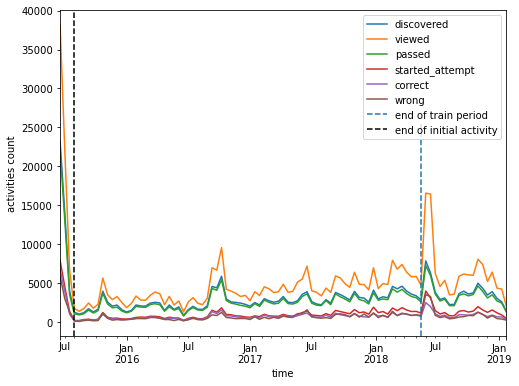

In [198]:
for action in all_actions.action.unique():
    action_by_month = pd.concat([all_actions_2d, all_actions_test])\
        .query('action == @action').resample('2W', on='time').action.count()
    action_by_month.plot(figsize=(8, 6), legend=True)

plt.axvline(all_actions_2d.time.max(), ymax=0.65, linestyle='--')
plt.axvline('2015-08-01',  linestyle='--', color='black')
plt.ylabel('activities count')
plt.legend(all_actions.action.unique().tolist() + ['end of train period', 'end of initial activity'], loc='upper right');

Видно, что в начале тренировочного периода (как только курс открылся, примерно до 1 августа 2016) активность зашкаливала по сравнению с остальным временем. Наверное, можно считать, что такая активность нетипична для среднего посетителя курса (как минимум, для предсказания было бы хорошо, чтобы тренировочная выборка была похожа на тестовую) и постараться ее обрезать.

Но и в начале тестовой выборки есть похожий скачок активности, как его объяснить? По идее, мы в начале тестового периода наоборот перестали регистрировать данные от пользователей из тренировочного периода (если разделение по юзерам было настоящим), то есть, активности должно стать меньше..

In [199]:
min_timestamps = get_min_timestamps(all_actions, as_datetime=True).min_timestamp
early_users = train_df[min_timestamps < '2015-08-01'].index.unique()
train_df[~train_df.index.isin(np.union1d(outlier_users, early_users))].iloc[:, :-1].describe()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
count,16098.000000,16098.000000,16098.000000,16098.000000,16098.000000,16098.000000,16098.000000
mean,12.063424,11.103926,4.015157,18.567648,3.032116,2.738042,1.333706
std,18.138287,16.887521,7.932444,30.960390,6.244149,8.715918,0.619882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,5.000000,4.000000,1.000000,6.000000,0.000000,0.000000,1.000000
75%,15.000000,13.000000,4.000000,22.000000,2.000000,1.000000,2.000000
max,198.000000,198.000000,116.000000,397.000000,76.000000,184.000000,3.000000


In [200]:
test_df.describe()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
count,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000
mean,10.877749,10.083603,4.344599,19.126132,2.825841,2.842820,1.303364
std,17.601541,16.496344,9.096022,41.319291,6.143144,10.725406,0.605769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,2.000000,2.000000,1.000000,3.000000,0.000000,0.000000,1.000000
75%,12.000000,11.000000,4.000000,17.000000,2.000000,0.000000,1.000000
max,180.000000,151.000000,113.000000,543.000000,46.000000,166.000000,3.000000


В общем, с этой штукой можно поиграться, но руками подобрать порог, при котором достигается близость по базовым статистикам с тестовой выборкой не удается (а надо ли?). Тут уже проще посмотреть как будет себя модель вести при отсечении по временному порогу снизу.

Можно автоматизированно попробовать поискать выбросы, хотя бы в самом простом признаковом пространстве. Попробуем сделать это с помощью ```IsolationForest``` из scikit-learn.

In [201]:
outliers_clf = IsolationForest(random_state=17)
forest_outliers = pd.Series(outliers_clf.fit_predict(train_df.iloc[:, :-1]), index=train_df.index)
forest_outliers.value_counts()

 1    15907
-1     3327
dtype: int64

По-хорошему, нам бы нужно сделать так, чтобы в тестовой выборке пользователей-выбросов не было или было мало? Ведь их-то мы не можем выкинуть.

In [202]:
pd.Series(outliers_clf.predict(test_df)).value_counts()

 1    5200
-1     984
dtype: int64

А тут выбросы есть. Можно, наверно, обучить ```LocalOutliersFactor``` на тестовой выборке и сделать novelty detection на тренировочной. Но это же читерство в чистом виде. 

In [203]:
pd.Series(forest_outliers, index=train_df.index)[outlier_users]

user_id
1046    -1
1078    -1
1361    -1
2261    -1
2514    -1
3572     1
4374     1
4762    -1
7702    -1
8363    -1
8394    -1
9104    -1
9546    -1
9880    -1
10353   -1
10782   -1
10794   -1
11770   -1
12133   -1
13268    1
20907   -1
20997   -1
25279   -1
26291   -1
26554    1
dtype: int32

Хотя бы отобранных руками юзеров он показывает как выбросы, кроме тех, которых явно только на основании выборки с полным объемом действий выловили.

In [204]:
forest_outlier_users = forest_outliers[forest_outliers == -1].index
np.savetxt(os.path.join(PATH_TO_DATA, 'forest_outlers_users.txt'), forest_outlier_users, fmt='%d')

Когда будем строить модель, то можно будет подгрузить усеченные списки пользователей (выкинуть отобранных вручную пользователей, отобранных отсечением порога по времени и отобранных моделью) и увидеть, улучшается ли качество модели.

# Исправление датасетов

Исправим аномалии с ```discovered``` и ```viewed```, которые видели раньше. Прибавим по единичке к ```discovered``` каждому юзеру столько раз, сколько у него было степов с ```discovered = 0``` (так как ```discovered``` для каждого степа бывает только 1 раз), и для не задачных степов прибавим то же число в ```passed```, так как ```discovered = passed``` для не задачных степов.

In [211]:
train_df_fixed = train_df.copy()
test_df_fixed = test_df.copy()

In [212]:
train_df_fixed[train_df.index.isin(undiscovered_non_problems_train.reset_index().user_id.unique())].discovered +=\
    undiscovered_non_problems_train.reset_index().user_id.value_counts().values
train_df_fixed[train_df.index.isin(undiscovered_non_problems_train.reset_index().user_id.unique())].passed +=\
    undiscovered_non_problems_train.reset_index().user_id.value_counts().values

train_df_fixed[train_df.index.isin(undiscovered_problems_train.reset_index().user_id.unique())].discovered +=\
    undiscovered_problems_train.reset_index().user_id.value_counts().values

test_df_fixed[test_df.index.isin(undiscovered_problems_test.reset_index().user_id.unique())].discovered +=\
    undiscovered_problems_test.reset_index().user_id.value_counts().values

Давайте попробуем также исправить тренировочный датасет для задачных степов с ```viewed = 0```. В отличие от ```passed``` и ```discovered```, пользователь может посмотреть степ неограниченное число раз, но медианное значение просмотров почти всех задачных степов по пользователям равно 1: 

In [213]:
all_actions_2d[(all_actions_2d.action == 'viewed') & (all_actions_2d.step_id.isin(problem_steps))].\
    groupby(['step_id', 'user_id'])[['timestamp']].count().rename(columns={'timestamp': 'num_viewed'}).\
    groupby('step_id').num_viewed.median().value_counts()

1    75
2     1
Name: num_viewed, dtype: int64

Так что можно просто прибавить по к графе ```viewed``` соответствующих юзеров в датасете число раз, которые они появились в ```unviewed_problems_train```, аналогично тому, что делали раньше (вспомним, что для тестовой выборки множества пар (юзер, степ) для задачных степов с ```discovered = 0``` и ```viewed = 0``` совпадают).

In [214]:
train_df_fixed[train_df.index.isin(unviewed_problems_train.reset_index().user_id.unique())].viewed +=\
    unviewed_problems_train.reset_index().user_id.value_counts().values

test_df_fixed[test_df.index.isin(undiscovered_problems_test.reset_index().user_id.unique())].viewed +=\
    undiscovered_problems_test.reset_index().user_id.value_counts().values

Сохраним исправленные выборки, потом проверим, улучшает ли исправление данных качество модели.

In [215]:
train_df_fixed.to_csv(os.path.join(PATH_TO_DATA, 'train_data_fixed.csv'))
test_df_fixed.to_csv(os.path.join(PATH_TO_DATA, 'test_data_fixed.csv'))

# FEATURE ENGINEERING

Степы на которых чаще всего заканчивают прохождение курса:

In [138]:
max_timestamps = events_2d.groupby('user_id').timestamp.max().reset_index().rename(columns={'timestamp': 'max_timestamp'})
last_events = events_2d[['user_id', 'step_id', 'action', 'timestamp']].merge(max_timestamps, on='user_id').\
    query('timestamp == max_timestamp').drop_duplicates(['user_id']).drop(columns='max_timestamp')
last_events.step_id.value_counts().head()

32815    1663
32927    1375
32191    1251
32950     736
32816     667
Name: step_id, dtype: int64

In [139]:
max_timestamps_submissions = submissions_2d.groupby('user_id').timestamp.max().reset_index().rename(columns={'timestamp': 'max_timestamp'})
last_submissions = submissions_2d[['user_id', 'step_id', 'submission_status', 'timestamp']].merge(max_timestamps_submissions, on='user_id').\
    query('timestamp == max_timestamp').drop_duplicates(['user_id']).drop(columns='max_timestamp')
last_submissions.step_id.value_counts().head(15)

32812     3749
31978     1542
32929      489
31977      486
32175      438
31972      403
31971      320
32206      236
31991      235
32219      184
32198      169
31979      160
120745     159
32202      148
32031      138
Name: step_id, dtype: int64

In [140]:
train_df[train_df.user_id.isin(last_events.query('step_id == 32953').user_id.values)].is_gone.value_counts()

0    232
1     86
Name: is_gone, dtype: int64

In [141]:
train_df[train_df.user_id.isin(last_submissions.query('step_id == 32812').user_id.values)].is_gone.value_counts()

0    3338
1     411
Name: is_gone, dtype: int64

Самые сложные степы по доле верных решений:

In [142]:
steps_submissions = submissions_2d.pivot_table(
    index='step_id',
    columns='submission_status',
    values='timestamp',
    aggfunc='count',
    fill_value=0
)
steps_submissions['correct_rate'] = steps_submissions.correct / (steps_submissions.correct + steps_submissions.wrong)
steps_submissions.sort_values(by='correct_rate', ascending=True).head(45).index

Int64Index([33481, 33669, 32202, 33685, 32031, 32206, 31978, 33332, 32809,
            32796, 33713, 33673, 31981, 33334, 32075, 32244, 33439, 33415,
            33350, 33992, 32174, 32810, 32795, 33079, 31979, 33731, 32198,
            31972, 32173, 33890, 33675, 33025, 33734, 31971, 31977, 33539,
            33534, 33677, 33540, 33536, 31976, 33482, 31983, 32763, 33684],
           dtype='int64', name='step_id')

In [323]:
non_problem_steps.shape[0] * 3 + problem_steps.shape[0] * 6

822

В принципе, можно нагенерировать вот столько фичей, просто сгруппировав про юзерам, степам и действиям. Но наверно такая штука в память не влезет?